# AWS Sagemaker Project: Mushroom

Le but de notre projet est de determiner si un champignon est comestible ou pas en fonction de plusieurs attributs

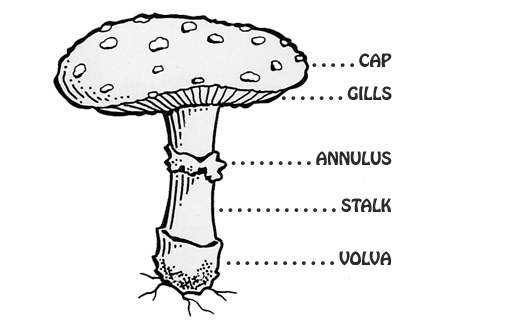

From the image, we can say that we have 5 main features of the mushroom:

    -Cap: which is the top part of the mushroom from above, which takes the umberlla shape.
    -Gill: which is the underside of the cap
    -Ring: which is this little shape that surround the stem (stalk).
    -Stalk (Stem): is what makes the mushroom standing, it's this vertical cylindrical.
    -Veil (Volva): which is the bottom shape of the mushroom, that covers the bottom part of the mushroom.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import io
from io import StringIO
import boto3
import sagemaker

pd.set_option('display.max_columns',23)

In [2]:
s3client = boto3.client(
    's3',
    region_name='us-west-1'
)

bucket='project-sagemaker-aws'
file_to_read = 'raw/mushrooms.csv' 

fileobj = s3client.get_object(Bucket=bucket, Key=file_to_read)
df = pd.read_csv(io.BytesIO(fileobj['Body'].read()))

## Data analysis

In [3]:
df.shape

(8124, 23)

In [4]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [5]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [27]:
df = df.drop(["veil-type"],axis=1)

plus de 8000 lignes 22 feature toute en categ , probleme de classification binaire ou le but est de determiné si un champignon est comestible ou pas.

On remarque que la colonne veil-type contient tout le temps la même donnée nous decidons donc de la supprimer.

Pour les autres on a entre 2 et 12 valeurs

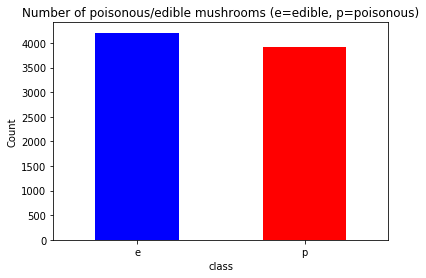

In [25]:
plt.figure()
pd.Series(df['class']).value_counts().sort_index().plot(kind = 'bar',color=('b','r'))
plt.ylabel("Count")
plt.xlabel("class")
plt.xticks(rotation=0)
plt.title('Number of poisonous/edible mushrooms (e=edible, p=poisonous)');

On vérifie que les données sont globalement bien répartie entre les 2 classes.

In [26]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

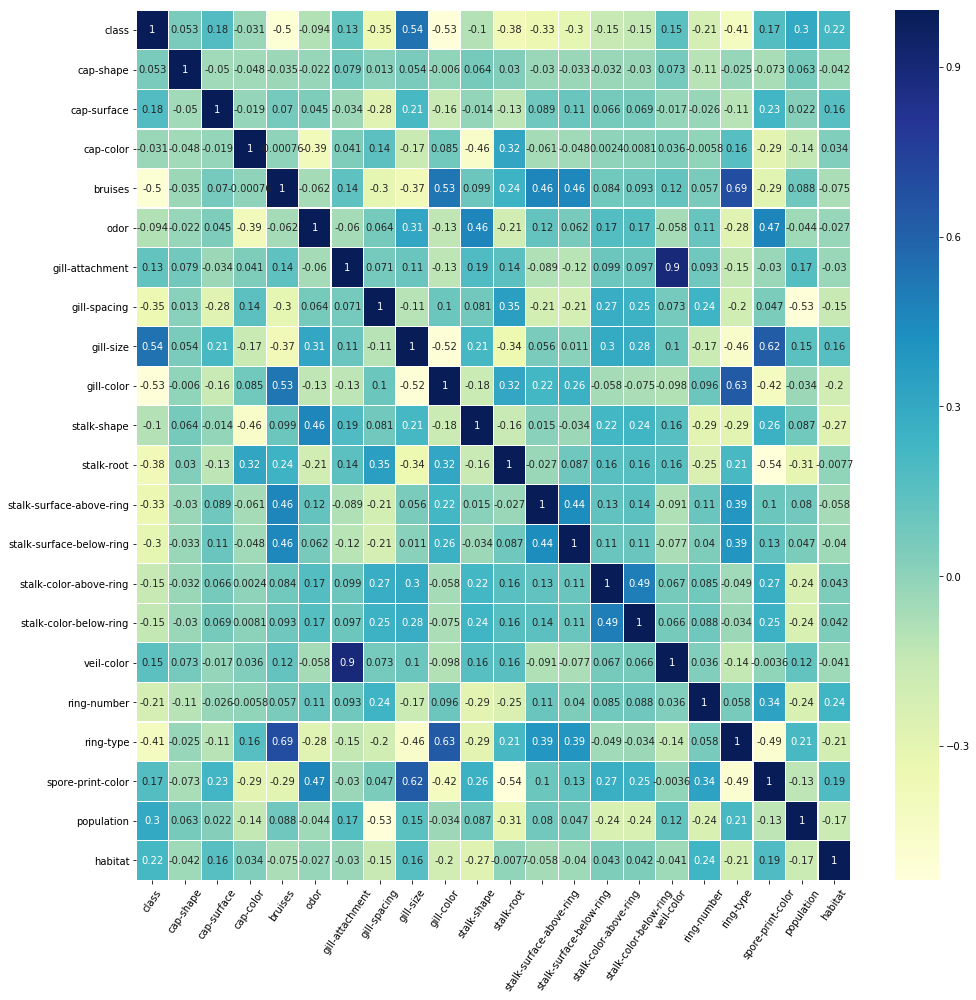

In [28]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=55)

On recherche une corrélation entre les différentes features.

## Dataset split into train test and validation

In [49]:
X = df.drop(['class'], axis=1)
Y = df['class']

In [36]:
temp_set, test_set = train_test_split(df, test_size=0.2)
train_set, valid_set = train_test_split(temp_set, test_size=0.25)

In [59]:
print('Training dataset: {}'.format(train_set.shape))
print('Validation dataset: {}'.format(valid_set.shape))
print('Test dataset: {}'.format(test_set.shape))

Training dataset: (4874, 23)
Validation dataset: (1625, 23)
Test dataset: (1625, 23)


# Stockage des dataset dans un compartiment S3
a completer


In [58]:
data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
for data_partition_name, data_partition in data_partitions:
    print('{}: {}'.format(data_partition_name, data_partition.shape))

    np.savetxt('data.csv', data_partition, delimiter=',')
    key = "{}/examples".format(data_partition_name)
    url = 's3://{}/{}'.format(bucket, key)
    s3client.upload_file('data.csv', bucket, key)
    print('Done writing to {}'.format(url))

train: (4874, 23)
Done writing to s3://project-sagemaker-aws/train/examples
validation: (1625, 23)
Done writing to s3://project-sagemaker-aws/validation/examples
test: (1625, 23)
Done writing to s3://project-sagemaker-aws/test/examples


In [60]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


In [61]:
train_data = 's3://{}/{}'.format(bucket, 'train')

validation_data = 's3://{}/{}'.format(bucket, 'validation')

s3_output_location = 's3://{}/{}'.format(bucket, 'xgboost_model_sdk')
print(train_data)

s3://project-sagemaker-aws/train


In [62]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [63]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 2,
                              num_round = 2)

In [64]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [65]:
xgb_model.fit(inputs=data_channels,  logs=True)

2020-01-10 11:55:58 Starting - Starting the training job...
2020-01-10 11:55:59 Starting - Launching requested ML instances...
2020-01-10 11:56:58 Starting - Preparing the instances for training.........
2020-01-10 11:58:21 Downloading - Downloading input data
2020-01-10 11:58:21 Training - Downloading the training image...
2020-01-10 11:58:52 Uploading - Uploading generated training model
2020-01-10 11:58:52 Completed - Training job completed
Arguments: train
[2020-01-10:11:58:41:INFO] Running standalone xgboost training.
[2020-01-10:11:58:41:INFO] File size need to be processed in the node: 3.56mb. Available memory size in the node: 8510.52mb
[2020-01-10:11:58:41:INFO] Determined delimiter of CSV input is ','
[11:58:41] S3DistributionType set as FullyReplicated
[11:58:41] 4874x22 matrix with 107228 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-01-10:11:58:41:INFO] Determined delimiter of CSV input is ','
[11:58:41] S3DistributionType set as 